In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
import matplotlib as mpl
from matplotlib import rc

SMALL_SIZE = 40
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

plt.rc('text', usetex=True)
plt.rc('font', size=11)

label_size = 13
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams.update({'font.size': label_size})

ftsize = 25

In [3]:
h = 0.67 

Obh2 = 0.02224
Och2 = 0.115422125 
omk = 0

mnu = 0.
num_massive_neutrinos = 0
nnu = 3.046

ns = 0.9632 
As = 2.2e-9

tau = 0. 

Tcmb = 2.7255 

z_eff = 1.

In [4]:
#generate matter power spectrum

kmin = 1e-4
kmax = 100.0
npoints = 200
k_per_logint = 30

pars = camb.CAMBparams()

pars.set_cosmology(H0=h*100, ombh2=Obh2, omch2=Och2, tau=tau, mnu = mnu, \
                   nnu = nnu, num_massive_neutrinos = num_massive_neutrinos, omk = omk, TCMB=Tcmb,)

pars.set_dark_energy(w=-1.)
pars.InitPower.set_params(As=As, ns=ns, r=0.)

pars.set_matter_power(redshifts=[0., z_eff], kmax=kmax, k_per_logint = k_per_logint)
pars.NonLinear = model.NonLinear_none

results = camb.get_results(pars)

kh, z, pk = results.get_matter_power_spectrum(minkh = kmin, maxkh = kmax, npoints = npoints, \
                                             var1  = 'delta_tot', var2  = 'delta_tot')
print(z)

klin, plin = kh, pk[1, :]

Note: redshifts have been re-sorted (earliest first)
[0.0, 1.0]


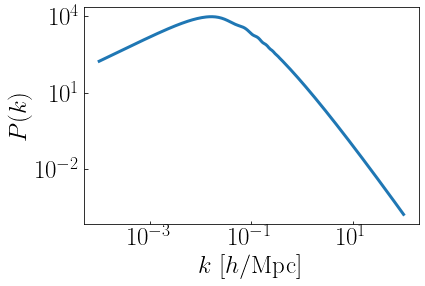

In [5]:
plt.loglog(klin, plin, lw=3)

plt.ylabel('$P(k)$', fontsize=ftsize)
plt.xlabel('$k~[h/\mathrm{Mpc}]$', fontsize=ftsize)

plt.tick_params(axis='both', which='major', labelsize=ftsize)
plt.tick_params(axis='both', which='minor', labelsize=ftsize)

plt.show()

In [6]:
#compute f
Om = (Obh2+Och2)/h**2

def D(z):
    OM = Om 
    OL = 1.-OM
    
    H = lambda x: 100.*np.sqrt(OM*(1.+x)**3+OL)
    function = lambda x: (1.+x)*(100./H(x))**3
    res, err = quad(function, z, np.inf)
    norm, err = quad(function, 0, np.inf)
    
    return (res/norm)*(H(z)/(100.))

z_arr = np.linspace(0, 2, 100)
Dz = np.array([D(z) for z in z_arr])

Dz_func = InterpolatedUnivariateSpline(z_arr, Dz, k=3)
f_func = lambda x: Dz_func.derivative(n=1)(x)*(-1)*(1+x)/Dz_func(x)

In [7]:
#set kaiser model

#bias
b1 = 2.7
f = f_func(z_eff)

#shot-noise
aP = 0 
e0k2 = 0
e2k2 = 0
Psn = 4690

Pstoch = lambda l, x: (0.125*l*l -0.75*l +1)*(1 + aP + e0k2 * x**2)*Psn + (-0.25*l*l + l)*e2k2*x**2*Psn

p0 = (b1**2 + 2/3*f*b1 + 1/5*f**2)*plin + Pstoch(0, klin)
p2 = (4/3*f*b1 + 4/7*f**2)*plin + Pstoch(2, klin)
p4 = 8/35*f**2*plin + Pstoch(4, klin)

p0_func = InterpolatedUnivariateSpline(klin, p0, k=3)
p2_func = InterpolatedUnivariateSpline(klin, p2, k=3)
p4_func = InterpolatedUnivariateSpline(klin, p4, k=3)

b1_fid, f_fid, aP_fid = b1, f, 0

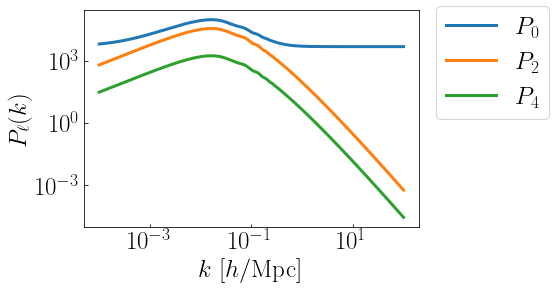

In [8]:
plt.loglog(klin, p0_func(klin), lw=3, label = '$P_0$')
plt.loglog(klin, p2_func(klin), lw=3, label = '$P_2$')
plt.loglog(klin, p4_func(klin), lw=3, label = '$P_4$')

plt.ylabel('$P_\ell(k)$', fontsize = ftsize)
plt.xlabel('$k~[h/\mathrm{Mpc}]$', fontsize = ftsize)

plt.tick_params(axis='both', which='major', labelsize=ftsize)
plt.tick_params(axis='both', which='minor', labelsize=ftsize)

plt.legend(loc = (1.05, 0.5), fontsize=ftsize)

In [9]:
#set specs for data

Lbox = 3780
kf = 2*np.pi/Lbox

Vol = (Lbox/1000)**3

dk, cf, Nb = 5, 4.5, 32
kh_data = np.arange(dk, (Nb-0.5)*dk+cf, dk)*kf
print(np.amin(kh_data), np.amax(kh_data))

Nk = 4*np.pi/(3*kf**3)*((kh_data+dk*kf/2)**3-(kh_data-dk*kf/2)**3)

0.008311091676163474 0.26595493363723116


In [10]:
#Vol_target = Vol
Vol_target = 6

eta = Vol_target/Vol

print(Vol)
print(Vol_target)
print(eta)

54.01015199999999
6
0.11109022614859519


(96, 96)


Text(-16, 81.0, '$P_4$')

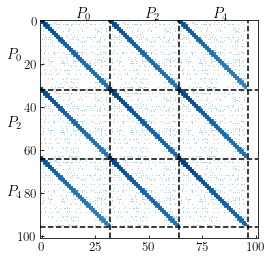

In [11]:
#generate data 

#the power spectrum
P0, P2, P4 = p0_func(kh_data), p2_func(kh_data), p4_func(kh_data)

#the (Gaussian) covariances
varP00 = 2/Nk*(P0**2 + 1/5*P2**2 + 1/9*P4**2)
varP02 = 1/Nk*(4*P0*P2 + 4/7*P2**2 + 8/7*P2*P4 + 200/693*P4**2)
varP04 = 1/Nk*(4*P0*P4 + 36/35*P2**2 + 80/77*P2*P4 + 324/1001*P4**2)

varP22 = 10/Nk*(P0**2 + 4/7*P0*(P2+P4) + 3/7*P2**2 + 24/77*P2*P4 + 1789/9009*P4**2)
varP24 = 1/Nk*(72/7*P0*P2 + 400/77*P0*P4 + 216/77*P2**2 + 2*3578/1001*P2*P4 + 1800/1001*P4**2)
varP44 = 162/Nk*(1/9*P0**2 + 40/693*P0*P2 + 36/1001*P0*P4 + 1789/45045*P2**2 + 40/1001*P2*P4 + 529/17017*P4**2)

varP00 = varP00/eta
varP02 = varP02/eta
varP04 = varP04/eta
varP22 = varP22/eta
varP24 = varP24/eta
varP44 = varP44/eta

P0_dat, P2_dat, P4_dat = P0, P2, P4

#'''
lP = len(varP00)
CovP_dat = np.zeros((3*lP, 3*lP))

CovP_dat[0*lP:1*lP, 0*lP:1*lP] = np.diag(varP00)
CovP_dat[1*lP:2*lP, 1*lP:2*lP] = np.diag(varP22)
CovP_dat[2*lP:3*lP, 2*lP:3*lP] = np.diag(varP44)

CovP_dat[1*lP:2*lP, 0*lP:1*lP] = np.diag(varP02)
CovP_dat[0*lP:1*lP, 1*lP:2*lP] = np.diag(varP02)

CovP_dat[2*lP:3*lP, 0*lP:1*lP] = np.diag(varP04)
CovP_dat[0*lP:1*lP, 2*lP:3*lP] = np.diag(varP04)

CovP_dat[1*lP:2*lP, 2*lP:3*lP] = np.diag(varP24)
CovP_dat[2*lP:3*lP, 1*lP:2*lP] = np.diag(varP24)

#'''

print(np.shape(CovP_dat))

from matplotlib.colors import LogNorm
plt.imshow(CovP_dat, cmap='Blues', norm=LogNorm(vmin=CovP_dat.min(), vmax=CovP_dat.max()))

plt.axhline(len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axhline(2*len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axhline(3*len(CovP_dat)/3, color = 'black', linestyle='dashed')

plt.axvline(len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axvline(2*len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axvline(3*len(CovP_dat)/3, color = 'black', linestyle='dashed')

plt.text(16, -2, '$P_0$', color='black', fontsize=15)
plt.text(16+len(CovP_dat)/3, -2, '$P_2$', color='black', fontsize=15)
plt.text(16+2*len(CovP_dat)/3, -2, '$P_4$', color='black', fontsize=15)

plt.text(-16, 17, '$P_0$', color='black', fontsize=15)
plt.text(-16, 17+len(CovP_dat)/3, '$P_2$', color='black', fontsize=15)
plt.text(-16, 17+2*len(CovP_dat)/3, '$P_4$', color='black', fontsize=15)


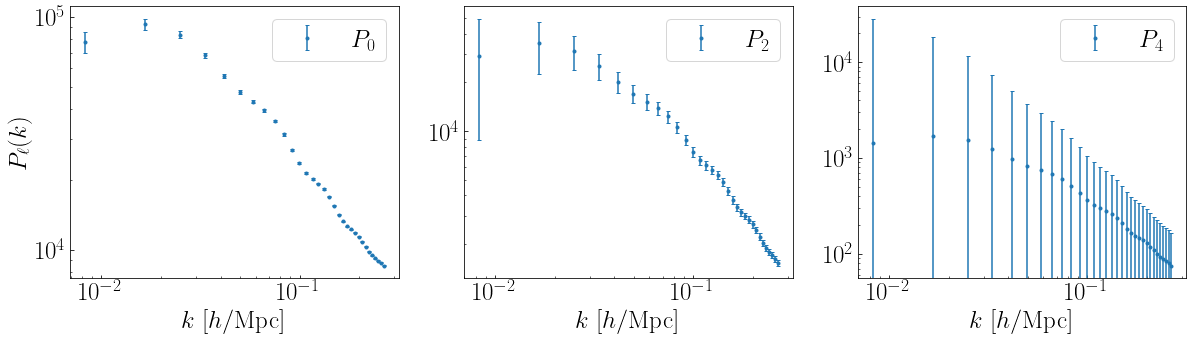

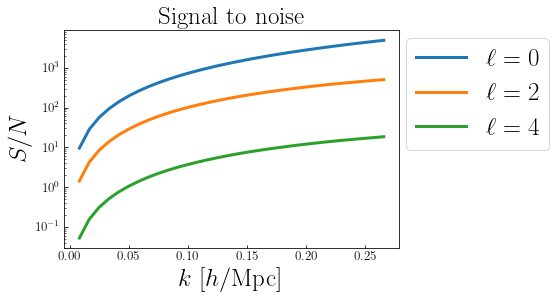

In [12]:
#plot data

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].errorbar(kh_data, P0_dat, yerr = varP00**(1/2), fmt = '.', capsize=2, label = '$P_0$')
ax[1].errorbar(kh_data, P2_dat, yerr = varP22**(1/2), fmt = '.', capsize=2, label = '$P_2$')
ax[2].errorbar(kh_data, P4_dat, yerr = varP44**(1/2), fmt = '.', capsize=2, label = '$P_4$')


for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('$k~[h/\mathrm{Mpc}]$', fontsize=ftsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ftsize)
    ax[i].tick_params(axis='both', which='minor', labelsize=ftsize)
    ax[i].legend(loc = 'upper right', fontsize=ftsize)

ax[0].set_ylabel('$P_\ell(k)$', fontsize=ftsize)
plt.show()


SignalNoise_0 = np.array([np.sum(P0_dat[0:i]/varP00[0:i]**(1/2)) for i in range (1, len(P0_dat)+1)])
SignalNoise_2 = np.array([np.sum(P2_dat[0:i]/varP22[0:i]**(1/2)) for i in range (1, len(P2_dat)+1)])
SignalNoise_4 = np.array([np.sum(P4_dat[0:i]/varP44[0:i]**(1/2)) for i in range (1, len(P4_dat)+1)])

plt.plot(kh_data, SignalNoise_0, lw=3, label = '$\ell=0$')
plt.plot(kh_data, SignalNoise_2, lw=3, label = '$\ell=2$')
plt.plot(kh_data, SignalNoise_4, lw=3, label = '$\ell=4$')

plt.yscale('log')
plt.ylabel('$S/N$', fontsize=ftsize)
plt.xlabel('$k~[h/\mathrm{Mpc}]$', fontsize=ftsize)
plt.legend(loc = (1.02, 0.45), fontsize=ftsize)
plt.title('$\mathrm{Signal~to~noise}$', fontsize=ftsize)
plt.show()

In [13]:
import emcee

In [14]:
plin_func = InterpolatedUnivariateSpline(klin, plin, k=3)
Plin = plin_func(kh_data)

#====Including P4:
#Pell_dat = np.hstack([P0_dat, P2_dat, P4_dat])
#CovP_dat = CovP_dat
#sign, logdet_CovP_dat = np.linalg.slogdet(CovP_dat)

#====Not including P4:
#Pell_dat = np.hstack([P0_dat_bin, P2_dat_bin])
Pell_dat = np.hstack([P0_dat, P2_dat])

CovP_dat = CovP_dat[0:2*len(P0_dat), 0:2*len(P0_dat)]
sign, logdet_CovP_dat = np.linalg.slogdet(CovP_dat)


In [15]:
b1_min, b1_max = 0, 5
f_min, f_max = 0, 1
aP_min, aP_max = -2, 2

def log_prior(theta):
    b1, f, aP = theta
    if b1_min < b1 < b1_max and f_min < f < f_max and aP_min < aP < aP_max:
        return 0.0
    return -np.inf

def log_likelihood(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat):
    b1, f, aP = theta
    
    P0 = (b1**2 + 2/3*f*b1 + 1/5*f**2)*Plin + (1+aP)*Psn
    P2 = (4/3*f*b1 + 4/7*f**2)*Plin 
    #P4 = 8/35*f**2*Plin 
    
    Pell_th = np.hstack([P0, P2])
    #Pell_th = np.hstack([P0, P2, P4])
    
    Delta_Pell = Pell_th - Pell_dat
    
    return -0.5*np.dot(Delta_Pell, np.linalg.solve(CovP_dat, Delta_Pell)) #+ logdet_CovP_dat

def log_probability(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat)

In [16]:
pos = np.array([1.6, 0.86, 0]) + 1e-1*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(Plin, Pell_dat, CovP_dat, logdet_CovP_dat)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/home/kevin/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████| 5000/5000 [00:24<00:00, 204.92it/s]


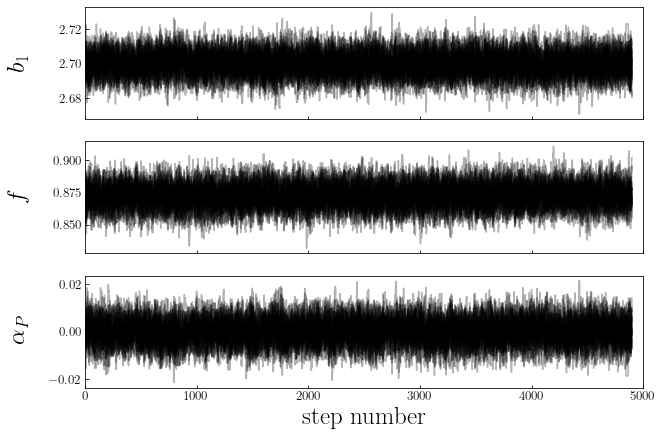

In [17]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_plot = ["$b_1$", "$f$", "$\\alpha_P$"]

ndiscard = 100

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[ndiscard:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_plot[i], fontsize=ftsize)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("$\mathrm{step~number}$", fontsize=ftsize);

In [18]:
flat_samples = sampler.get_chain(discard=ndiscard, thin=15, flat=True)
print(flat_samples.shape)

fname = 'result_Vol%d.txt' %Vol_target
np.savetxt(fname, flat_samples)

(10432, 3)


In [19]:
flat_samples_Vol6 = np.loadtxt('result_Vol6.txt')

In [22]:
from getdist import plots, MCSamples

label_legend = ['vol6']

ranges = {'b1':  [b1_min, b1_max],  'f': [f_min,f_max], 'aP': [aP_min, aP_max]}
names = ['b1', 'f', 'aP']
labels = [r'b_1', r'f', r'\alpha_P']
fiducials = {'b1': b1_fid, 'f': f_fid, 'aP': aP_fid}


samples1 = MCSamples(ranges=ranges, samples=flat_samples_Vol6,
                     names=names, labels=labels, settings = {'smooth_scale_2D':0.3}, label=label_legend[0])


Removed no burn in


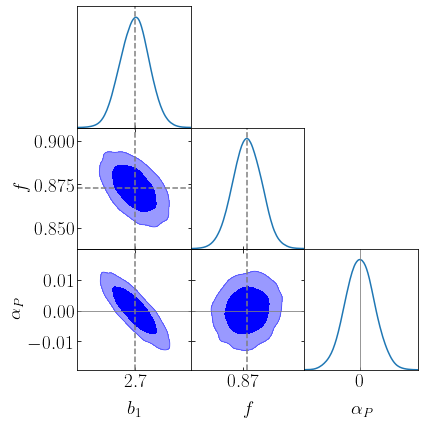

In [23]:
# Triangle plot
g = plots.get_subplot_plotter()
g.settings.alpha_filled_add=0.75
g.settings.axes_fontsize = 22
g.settings.lab_fontsize = 22
g.settings.legend_fontsize = 25
g.settings.lw_contour = 1.5

legend_loc_ = 'upper right'

g.triangle_plot([samples1], \
                contour_colors=['blue', 'green'], \
                line_args=[{'lw':1.5, 'color':'tab:blue'}, \
                           {'lw':1.5, 'color':'tab:green'}], \
                legend_loc= legend_loc_, filled=[True,True])

if fiducials != None:
    for i in range(len(names)):
        for j in range(i+1):
            ax = g.subplots[i,j]
            if i != j and names[i] in fiducials:
                                
                if names[i][0] != "a":
                    ax.axhline(fiducials[names[i]],ls='--',
                               color='tab:gray')
                else:                    
                    ax.axhline(fiducials[names[i]],ls='-',lw=0.8,
                               color='tab:gray')
                
                
            if names[j] in fiducials:
                
                
                if names[j][0] != "a":
                    ax.axvline(fiducials[names[j]],ls='--',
                               color='tab:gray')
                else:
                    ax.axvline(fiducials[names[j]],ls='-',lw=0.8,
                               color='tab:gray')

#plt.savefig('name.png', dpi = 300, bbox_inches = 'tight', facecolor = 'white', transparent='False')

print()

# Consider a survey with 10x larger volume

In [24]:
#set specs for data

Lbox = 3780
kf = 2*np.pi/Lbox

Vol = (Lbox/1000)**3

dk, cf, Nb = 5, 4.5, 32
kh_data = np.arange(dk, (Nb-0.5)*dk+cf, dk)*kf
print(np.amin(kh_data), np.amax(kh_data))

Nk = 4*np.pi/(3*kf**3)*((kh_data+dk*kf/2)**3-(kh_data-dk*kf/2)**3)

0.008311091676163474 0.26595493363723116


In [25]:
#Vol_target = Vol
Vol_target = 60

eta = Vol_target/Vol

print(Vol)
print(Vol_target)
print(eta)

54.01015199999999
60
1.1109022614859518


(96, 96)


Text(-16, 81.0, '$P_4$')

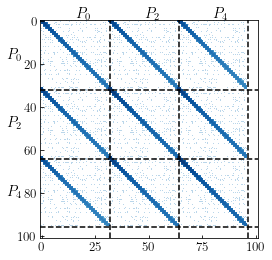

In [26]:
#generate data 

#the power spectrum
P0, P2, P4 = p0_func(kh_data), p2_func(kh_data), p4_func(kh_data)

#the (Gaussian) covariances
varP00 = 2/Nk*(P0**2 + 1/5*P2**2 + 1/9*P4**2)
varP02 = 1/Nk*(4*P0*P2 + 4/7*P2**2 + 8/7*P2*P4 + 200/693*P4**2)
varP04 = 1/Nk*(4*P0*P4 + 36/35*P2**2 + 80/77*P2*P4 + 324/1001*P4**2)

varP22 = 10/Nk*(P0**2 + 4/7*P0*(P2+P4) + 3/7*P2**2 + 24/77*P2*P4 + 1789/9009*P4**2)
varP24 = 1/Nk*(72/7*P0*P2 + 400/77*P0*P4 + 216/77*P2**2 + 2*3578/1001*P2*P4 + 1800/1001*P4**2)
varP44 = 162/Nk*(1/9*P0**2 + 40/693*P0*P2 + 36/1001*P0*P4 + 1789/45045*P2**2 + 40/1001*P2*P4 + 529/17017*P4**2)

varP00 = varP00/eta
varP02 = varP02/eta
varP04 = varP04/eta
varP22 = varP22/eta
varP24 = varP24/eta
varP44 = varP44/eta

P0_dat, P2_dat, P4_dat = P0, P2, P4

#'''
lP = len(varP00)
CovP_dat = np.zeros((3*lP, 3*lP))

CovP_dat[0*lP:1*lP, 0*lP:1*lP] = np.diag(varP00)
CovP_dat[1*lP:2*lP, 1*lP:2*lP] = np.diag(varP22)
CovP_dat[2*lP:3*lP, 2*lP:3*lP] = np.diag(varP44)

CovP_dat[1*lP:2*lP, 0*lP:1*lP] = np.diag(varP02)
CovP_dat[0*lP:1*lP, 1*lP:2*lP] = np.diag(varP02)

CovP_dat[2*lP:3*lP, 0*lP:1*lP] = np.diag(varP04)
CovP_dat[0*lP:1*lP, 2*lP:3*lP] = np.diag(varP04)

CovP_dat[1*lP:2*lP, 2*lP:3*lP] = np.diag(varP24)
CovP_dat[2*lP:3*lP, 1*lP:2*lP] = np.diag(varP24)

#'''

print(np.shape(CovP_dat))

from matplotlib.colors import LogNorm
plt.imshow(CovP_dat, cmap='Blues', norm=LogNorm(vmin=CovP_dat.min(), vmax=CovP_dat.max()))

plt.axhline(len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axhline(2*len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axhline(3*len(CovP_dat)/3, color = 'black', linestyle='dashed')

plt.axvline(len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axvline(2*len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axvline(3*len(CovP_dat)/3, color = 'black', linestyle='dashed')

plt.text(16, -2, '$P_0$', color='black', fontsize=15)
plt.text(16+len(CovP_dat)/3, -2, '$P_2$', color='black', fontsize=15)
plt.text(16+2*len(CovP_dat)/3, -2, '$P_4$', color='black', fontsize=15)

plt.text(-16, 17, '$P_0$', color='black', fontsize=15)
plt.text(-16, 17+len(CovP_dat)/3, '$P_2$', color='black', fontsize=15)
plt.text(-16, 17+2*len(CovP_dat)/3, '$P_4$', color='black', fontsize=15)


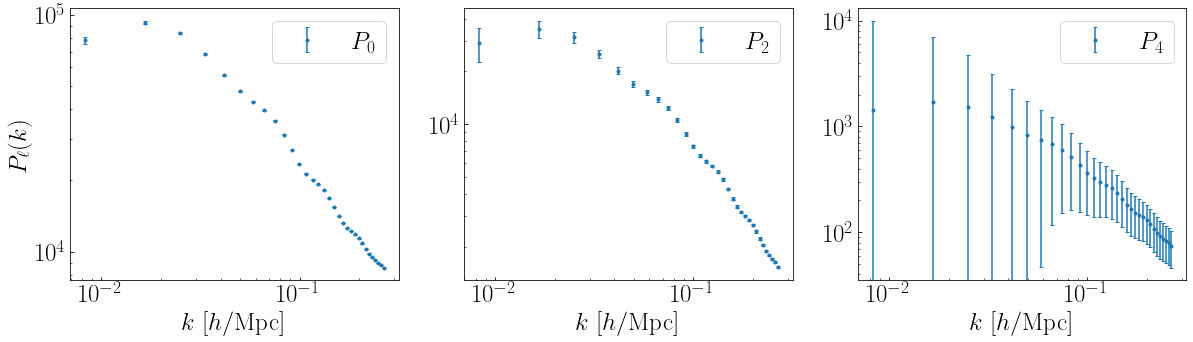

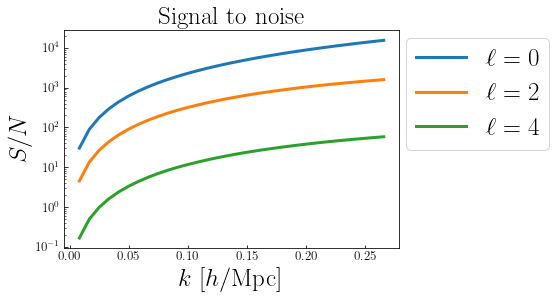

In [27]:
#plot data

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].errorbar(kh_data, P0_dat, yerr = varP00**(1/2), fmt = '.', capsize=2, label = '$P_0$')
ax[1].errorbar(kh_data, P2_dat, yerr = varP22**(1/2), fmt = '.', capsize=2, label = '$P_2$')
ax[2].errorbar(kh_data, P4_dat, yerr = varP44**(1/2), fmt = '.', capsize=2, label = '$P_4$')

for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('$k~[h/\mathrm{Mpc}]$', fontsize=ftsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ftsize)
    ax[i].tick_params(axis='both', which='minor', labelsize=ftsize)
    ax[i].legend(loc = 'upper right', fontsize=ftsize)

ax[0].set_ylabel('$P_\ell(k)$', fontsize=ftsize)
plt.show()


SignalNoise_0 = np.array([np.sum(P0_dat[0:i]/varP00[0:i]**(1/2)) for i in range (1, len(P0_dat)+1)])
SignalNoise_2 = np.array([np.sum(P2_dat[0:i]/varP22[0:i]**(1/2)) for i in range (1, len(P2_dat)+1)])
SignalNoise_4 = np.array([np.sum(P4_dat[0:i]/varP44[0:i]**(1/2)) for i in range (1, len(P4_dat)+1)])

plt.plot(kh_data, SignalNoise_0, lw=3, label = '$\ell=0$')
plt.plot(kh_data, SignalNoise_2, lw=3, label = '$\ell=2$')
plt.plot(kh_data, SignalNoise_4, lw=3, label = '$\ell=4$')

plt.yscale('log')
plt.ylabel('$S/N$', fontsize=ftsize)
plt.xlabel('$k~[h/\mathrm{Mpc}]$', fontsize=ftsize)
plt.legend(loc = (1.02, 0.45), fontsize=ftsize)
plt.title('$\mathrm{Signal~to~noise}$', fontsize=ftsize)
plt.show()

In [28]:
plin_func = InterpolatedUnivariateSpline(klin, plin, k=3)
Plin = plin_func(kh_data)

#====Including P4:
#Pell_dat = np.hstack([P0_dat, P2_dat, P4_dat])
#CovP_dat = CovP_dat
#sign, logdet_CovP_dat = np.linalg.slogdet(CovP_dat)

#====Not including P4:
#Pell_dat = np.hstack([P0_dat_bin, P2_dat_bin])
Pell_dat = np.hstack([P0_dat, P2_dat])

CovP_dat = CovP_dat[0:2*len(P0_dat), 0:2*len(P0_dat)]
sign, logdet_CovP_dat = np.linalg.slogdet(CovP_dat)


In [29]:
b1_min, b1_max = 0, 5
f_min, f_max = 0, 1
aP_min, aP_max = -2, 2

def log_prior(theta):
    b1, f, aP = theta
    if b1_min < b1 < b1_max and f_min < f < f_max and aP_min < aP < aP_max:
        return 0.0
    return -np.inf

def log_likelihood(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat):
    b1, f, aP = theta
    
    P0 = (b1**2 + 2/3*f*b1 + 1/5*f**2)*Plin + (1+aP)*Psn
    P2 = (4/3*f*b1 + 4/7*f**2)*Plin 
    #P4 = 8/35*f**2*Plin 
    
    Pell_th = np.hstack([P0, P2])
    #Pell_th = np.hstack([P0, P2, P4])
    
    Delta_Pell = Pell_th - Pell_dat
    
    return -0.5*np.dot(Delta_Pell, np.linalg.solve(CovP_dat, Delta_Pell)) #+ logdet_CovP_dat

def log_probability(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat)

In [30]:
pos = np.array([1.6, 0.86, 0]) + 1e-1*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(Plin, Pell_dat, CovP_dat, logdet_CovP_dat)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/home/kevin/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████| 5000/5000 [00:28<00:00, 177.77it/s]


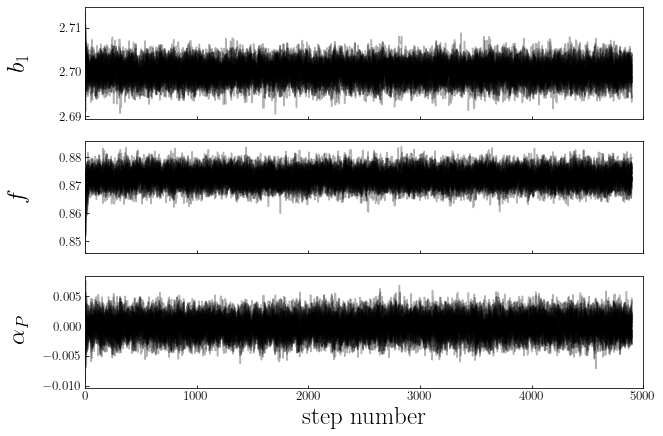

In [31]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_plot = ["$b_1$", "$f$", "$\\alpha_P$"]

ndiscard = 100

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[ndiscard:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_plot[i], fontsize=ftsize)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("$\mathrm{step~number}$", fontsize=ftsize);

In [32]:
flat_samples = sampler.get_chain(discard=ndiscard, thin=15, flat=True)
print(flat_samples.shape)

fname = 'result_Vol%d.txt' %Vol_target
np.savetxt(fname, flat_samples)

(10432, 3)


In [33]:
#Load data

flat_samples_Vol6 = np.loadtxt('result_Vol6.txt')
flat_samples_Vol60 = np.loadtxt('result_Vol60.txt')

In [34]:
from getdist import plots, MCSamples

label_legend = ['vol6', 'vol60']

ranges = {'b1':  [b1_min, b1_max],  'f': [f_min,f_max], 'aP': [aP_min, aP_max]}
names = ['b1', 'f', 'aP']
labels = [r'b_1', r'f', r'\alpha_P']
fiducials = {'b1': b1_fid, 'f': f_fid, 'aP': aP_fid}


samples1 = MCSamples(ranges=ranges, samples=flat_samples_Vol6,
                     names=names, labels=labels, settings = {'smooth_scale_2D':0.3}, label=label_legend[0])
samples2 = MCSamples(ranges=ranges, samples=flat_samples_Vol60,
                     names=names, labels=labels, settings = {'smooth_scale_2D':0.3}, label=label_legend[1])


Removed no burn in
Removed no burn in


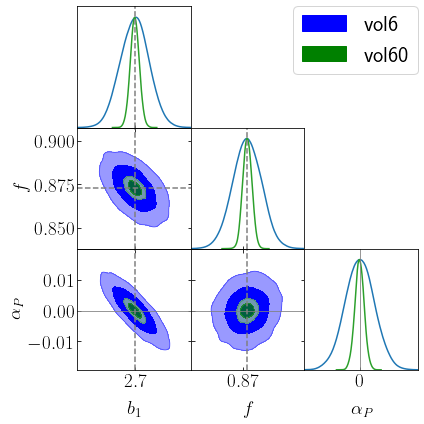

In [35]:
# Triangle plot
g = plots.get_subplot_plotter()
g.settings.alpha_filled_add=0.75
g.settings.axes_fontsize = 22
g.settings.lab_fontsize = 22
g.settings.legend_fontsize = 25
g.settings.lw_contour = 1.5

legend_loc_ = 'upper right'

g.triangle_plot([samples1, samples2], \
                contour_colors=['blue', 'green'], \
                line_args=[{'lw':1.5, 'color':'tab:blue'}, \
                           {'lw':1.5, 'color':'tab:green'}], \
                legend_loc= legend_loc_, filled=[True,True])

if fiducials != None:
    for i in range(len(names)):
        for j in range(i+1):
            ax = g.subplots[i,j]
            if i != j and names[i] in fiducials:
                                
                if names[i][0] != "a":
                    ax.axhline(fiducials[names[i]],ls='--',
                               color='tab:gray')
                else:                    
                    ax.axhline(fiducials[names[i]],ls='-',lw=0.8,
                               color='tab:gray')
                
                
            if names[j] in fiducials:
                
                
                if names[j][0] != "a":
                    ax.axvline(fiducials[names[j]],ls='--',
                               color='tab:gray')
                else:
                    ax.axvline(fiducials[names[j]],ls='-',lw=0.8,
                               color='tab:gray')

#plt.savefig('name.png', dpi = 300, bbox_inches = 'tight', facecolor = 'white', transparent='False')

print()

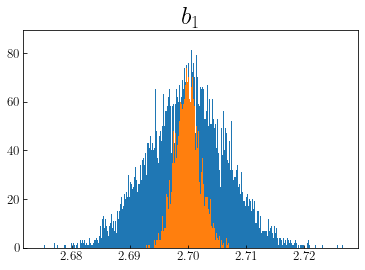

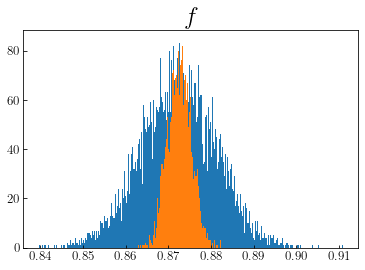

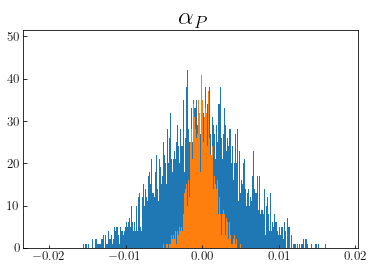

Ratio of sigma(b1): 3.1770192125338013
Ratio of sigma(f): 3.1859065323868614
Ratio of sigma(aP): 3.173516010817032
sqrt(60/6): 3.1622776601683795


In [36]:
#print(np.shape(flat_samples_Vol6))

plt.hist(flat_samples_Vol6[:, 0], bins = 500)
plt.hist(flat_samples_Vol60[:, 0], bins = 500)
plt.title('$b_1$', fontsize=ftsize)
plt.show()

plt.hist(flat_samples_Vol6[:, 1], bins = 500)
plt.hist(flat_samples_Vol60[:, 1], bins = 500)
plt.title('$f$', fontsize=ftsize)
plt.show()

plt.hist(flat_samples_Vol6[:, 2], bins = 1000)
plt.hist(flat_samples_Vol60[:, 2], bins = 1000)
plt.title('$\\alpha_P$', fontsize=ftsize)
plt.show()

sigma_b1_Vol6 = np.std(flat_samples_Vol6[:, 0])
sigma_b1_Vol60 = np.std(flat_samples_Vol60[:, 0])

sigma_f_Vol6 = np.std(flat_samples_Vol6[:, 1])
sigma_f_Vol60 = np.std(flat_samples_Vol60[:, 1])

sigma_aP_Vol6 = np.std(flat_samples_Vol6[:, 2])
sigma_aP_Vol60 = np.std(flat_samples_Vol60[:, 2])

print('Ratio of sigma(b1):', sigma_b1_Vol6/sigma_b1_Vol60)
print('Ratio of sigma(f):',sigma_f_Vol6/sigma_f_Vol60)
print('Ratio of sigma(aP):',sigma_aP_Vol6/sigma_aP_Vol60)
print('sqrt(60/6):', np.sqrt(60/6))

# data with "systematics"

In [37]:
#set specs for data

Lbox = 3780
kf = 2*np.pi/Lbox

Vol = (Lbox/1000)**3

dk, cf, Nb = 5, 4.5, 32
kh_data = np.arange(dk, (Nb-0.5)*dk+cf, dk)*kf
print(np.amin(kh_data), np.amax(kh_data))

Nk = 4*np.pi/(3*kf**3)*((kh_data+dk*kf/2)**3-(kh_data-dk*kf/2)**3)

0.008311091676163474 0.26595493363723116


In [38]:
#Vol_target = Vol
Vol_target = 6

eta = Vol_target/Vol

print(Vol)
print(Vol_target)
print(eta)

54.01015199999999
6
0.11109022614859519


(96, 96)


Text(-16, 81.0, '$P_4$')

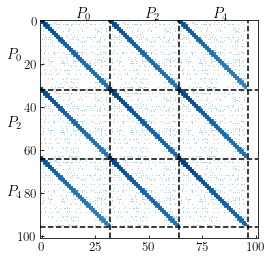

In [39]:
#generate data 

#the power spectrum
P0, P2, P4 = p0_func(kh_data), p2_func(kh_data), p4_func(kh_data)

#the (Gaussian) covariances
varP00 = 2/Nk*(P0**2 + 1/5*P2**2 + 1/9*P4**2)
varP02 = 1/Nk*(4*P0*P2 + 4/7*P2**2 + 8/7*P2*P4 + 200/693*P4**2)
varP04 = 1/Nk*(4*P0*P4 + 36/35*P2**2 + 80/77*P2*P4 + 324/1001*P4**2)

varP22 = 10/Nk*(P0**2 + 4/7*P0*(P2+P4) + 3/7*P2**2 + 24/77*P2*P4 + 1789/9009*P4**2)
varP24 = 1/Nk*(72/7*P0*P2 + 400/77*P0*P4 + 216/77*P2**2 + 2*3578/1001*P2*P4 + 1800/1001*P4**2)
varP44 = 162/Nk*(1/9*P0**2 + 40/693*P0*P2 + 36/1001*P0*P4 + 1789/45045*P2**2 + 40/1001*P2*P4 + 529/17017*P4**2)

varP00 = varP00/eta
varP02 = varP02/eta
varP04 = varP04/eta
varP22 = varP22/eta
varP24 = varP24/eta
varP44 = varP44/eta

P0_dat, P2_dat, P4_dat = P0, P2, P4

#'''
lP = len(varP00)
CovP_dat = np.zeros((3*lP, 3*lP))

CovP_dat[0*lP:1*lP, 0*lP:1*lP] = np.diag(varP00)
CovP_dat[1*lP:2*lP, 1*lP:2*lP] = np.diag(varP22)
CovP_dat[2*lP:3*lP, 2*lP:3*lP] = np.diag(varP44)

CovP_dat[1*lP:2*lP, 0*lP:1*lP] = np.diag(varP02)
CovP_dat[0*lP:1*lP, 1*lP:2*lP] = np.diag(varP02)

CovP_dat[2*lP:3*lP, 0*lP:1*lP] = np.diag(varP04)
CovP_dat[0*lP:1*lP, 2*lP:3*lP] = np.diag(varP04)

CovP_dat[1*lP:2*lP, 2*lP:3*lP] = np.diag(varP24)
CovP_dat[2*lP:3*lP, 1*lP:2*lP] = np.diag(varP24)

#'''

print(np.shape(CovP_dat))

from matplotlib.colors import LogNorm
plt.imshow(CovP_dat, cmap='Blues', norm=LogNorm(vmin=CovP_dat.min(), vmax=CovP_dat.max()))

plt.axhline(len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axhline(2*len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axhline(3*len(CovP_dat)/3, color = 'black', linestyle='dashed')

plt.axvline(len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axvline(2*len(CovP_dat)/3, color = 'black', linestyle='dashed')
plt.axvline(3*len(CovP_dat)/3, color = 'black', linestyle='dashed')

plt.text(16, -2, '$P_0$', color='black', fontsize=15)
plt.text(16+len(CovP_dat)/3, -2, '$P_2$', color='black', fontsize=15)
plt.text(16+2*len(CovP_dat)/3, -2, '$P_4$', color='black', fontsize=15)

plt.text(-16, 17, '$P_0$', color='black', fontsize=15)
plt.text(-16, 17+len(CovP_dat)/3, '$P_2$', color='black', fontsize=15)
plt.text(-16, 17+2*len(CovP_dat)/3, '$P_4$', color='black', fontsize=15)


In [40]:
#generate data with discrete binning "systematics"

from math import floor
import numba as nb

@nb.jit(nopython = True)
def R_PP(P0, P2, P4, mu, res):
    L0 = 1
    L2 = 0.5*(-1 + 3*mu*mu)
    L4 = 0.125*(3 - 30*mu*mu + 35*mu*mu*mu*mu)
    
    Ptot = L0*P0 + L2*P2 + L4*P4
    
    res[0] = 1*L0*Ptot
    res[1] = 5*L2*Ptot
    res[2] = 9*L4*Ptot
    
#-------------------------------------------------------------
dk, cf, Nb = dk, cf, Nb

kf = 2.*np.pi/Lbox

kmin = cf-0.5*dk
kmax = (Nb-0.5)*dk+cf
L = int(floor(kmax))
L2 = int(kmax*kmax)

kVals2 = np.arange(3.*L*L+1.)
kVals = np.sqrt(kVals2)

p0_table = np.array([p0_func(i*kf) for i in kVals])
p2_table = np.array([p2_func(i*kf) for i in kVals])
p4_table = np.array([p4_func(i*kf) for i in kVals])

Nterms = 3

#-------------------------------------------------------------
BinF = np.zeros((Nterms, Nb))
Nk   = np.zeros(Nb)

@nb.jit(nopython = True)
def bin_POWER(L, kVals, BinF, p0_table, p2_table, p4_table, Nk, kmin, kmax, dk):
    mult = 0
    I = 0
    res = np.zeros(Nterms)
    for x in nb.prange(0, L+1):
        for y in nb.prange(0, L+1):
            for z in nb.prange(0, L+1):
                k2 = x*x+y*y+z*z
                k  = kVals[k2]
                
                if k == 0:
                    mu = 1
                else:
                    mu = z/k
                
                if kmin <= k <= kmax:
                    mult = 8 >> (int(x == 0) + int(y == 0) + int(z == 0))
                    I = int((k - kmin)/dk)

                    P0 = p0_table[k2]
                    P2 = p2_table[k2]
                    P4 = p4_table[k2]

                    R_PP(P0, P2, P4, mu, res)
                    for h in range(len(res)):
                        BinF[h, I] += res[h]*mult
                                      
                    #BinF[I] += mult*(p0_table[k2] + p2_table[k2]*legendre_2(mu) + p4_table[k2]*legendre_4(mu))\
                    #              *legendre_4(mu)*(2*4 + 1)                                  
                    
                    Nk[I] += mult

bin_POWER(L, kVals, BinF, p0_table, p2_table, p4_table, Nk, kmin, kmax, dk)
BinF /= Nk

kh = np.array([cf + (i-1)*dk for i in range(1, Nb+1)])*kf

P0_dat_bin, P2_dat_bin, P4_dat_bin = BinF

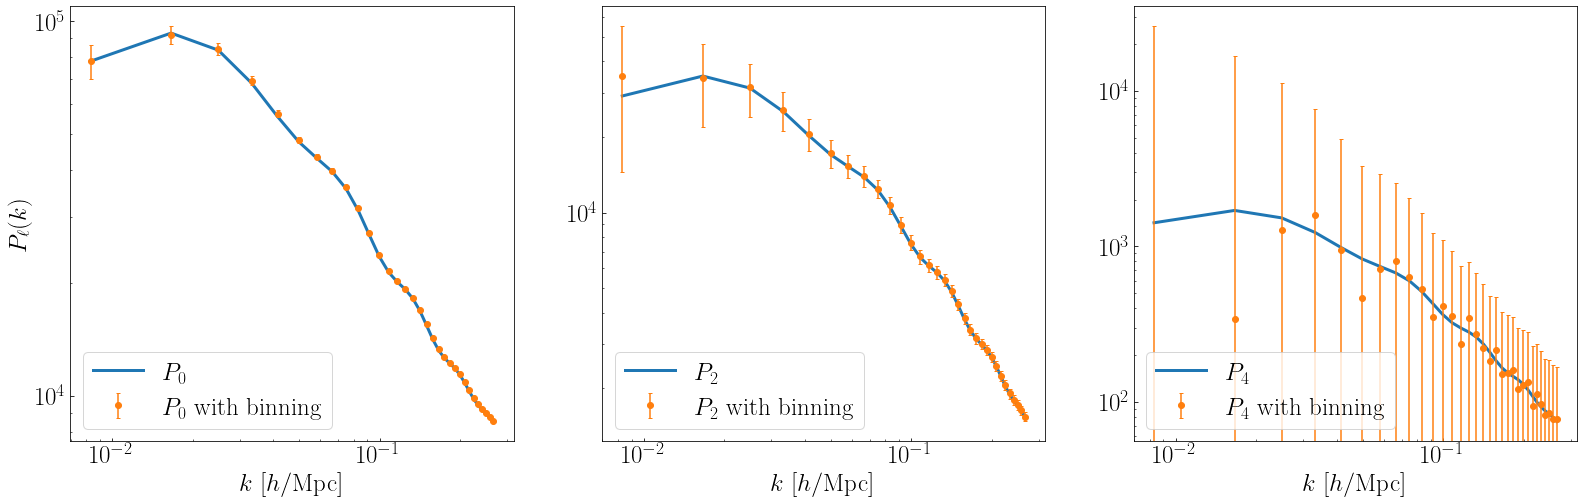

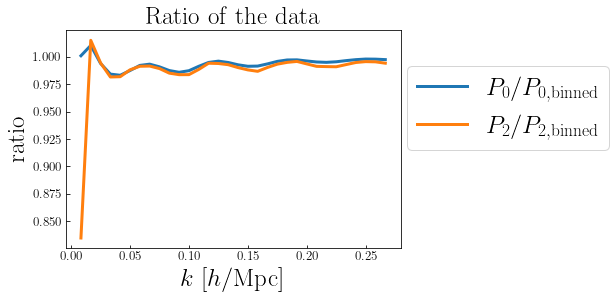

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(27, 8))
ax[0].plot(kh_data, P0, lw = 3, label = '$P_0$')
ax[0].errorbar(kh_data, P0_dat_bin, yerr = varP00**(1/2), fmt = 'o', capsize=2, label = '$P_0~\mathrm{with~binning}$')

ax[1].plot(kh_data, P2, lw = 3, label = '$P_2$')
ax[1].errorbar(kh_data, P2_dat_bin, yerr = varP22**(1/2), fmt = 'o', capsize=2, label = '$P_2~\mathrm{with~binning}$')

ax[2].plot(kh_data, P4, lw = 3, label = '$P_4$')
ax[2].errorbar(kh_data, P4_dat_bin, yerr = varP44**(1/2), fmt = 'o', capsize=2, label = '$P_4~\mathrm{with~binning}$')

for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('$k~[h/\mathrm{Mpc}]$', fontsize=ftsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ftsize)
    ax[i].tick_params(axis='both', which='minor', labelsize=ftsize)
    ax[i].legend(loc = 'lower left', fontsize=ftsize)

ax[0].set_ylabel('$P_\ell(k)$', fontsize=ftsize)
plt.show()

plt.plot(kh_data, P0_dat/P0_dat_bin, lw = 3, label = '$P_0/P_{0, \mathrm{binned}}$')
plt.plot(kh_data, P2_dat/P2_dat_bin, lw = 3, label = '$P_2/P_{2, \mathrm{binned}}$')

plt.ylabel('$\mathrm{ratio}$', fontsize=ftsize)
plt.xlabel('$k~[h/\mathrm{Mpc}]$', fontsize=ftsize)
plt.legend(loc = (1.02, 0.45), fontsize=ftsize)
plt.title('$\mathrm{Ratio~of~the~data}$', fontsize=ftsize)
plt.show()

In [43]:
plin_func = InterpolatedUnivariateSpline(klin, plin, k=3)
Plin = plin_func(kh_data)

Pell_dat = np.hstack([P0_dat_bin, P2_dat_bin])

CovP_dat = CovP_dat[0:2*len(P0_dat), 0:2*len(P0_dat)]
sign, logdet_CovP_dat = np.linalg.slogdet(CovP_dat)


In [44]:
b1_min, b1_max = 0, 5
f_min, f_max = 0, 1
aP_min, aP_max = -2, 2

def log_prior(theta):
    b1, f, aP = theta
    if b1_min < b1 < b1_max and f_min < f < f_max and aP_min < aP < aP_max:
        return 0.0
    return -np.inf

def log_likelihood(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat):
    b1, f, aP = theta
    
    P0 = (b1**2 + 2/3*f*b1 + 1/5*f**2)*Plin + (1+aP)*Psn
    P2 = (4/3*f*b1 + 4/7*f**2)*Plin 
    
    Pell_th = np.hstack([P0, P2])
    
    Delta_Pell = Pell_th - Pell_dat
    
    return -0.5*np.dot(Delta_Pell, np.linalg.solve(CovP_dat, Delta_Pell)) #+ logdet_CovP_dat

def log_probability(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Plin, Pell_dat, CovP_dat, logdet_CovP_dat)

In [45]:
pos = np.array([1.6, 0.86, 0]) + 1e-1*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(Plin, Pell_dat, CovP_dat, logdet_CovP_dat)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/home/kevin/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████| 5000/5000 [00:26<00:00, 189.55it/s]


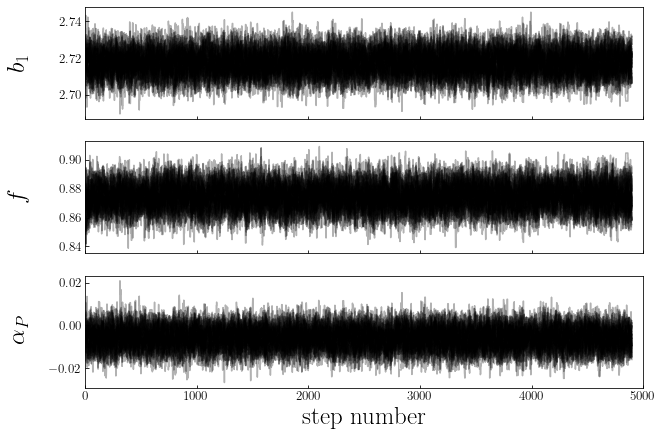

In [50]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_plot = ["$b_1$", "$f$", "$\\alpha_P$"]

ndiscard = 100

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[ndiscard:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_plot[i], fontsize=ftsize)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("$\mathrm{step~number}$", fontsize=ftsize);

In [51]:
flat_samples = sampler.get_chain(discard=ndiscard, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


In [54]:
from getdist import plots, MCSamples

ranges = {'b1':  [b1_min, b1_max],  'f': [f_min,f_max], 'aP': [aP_min, aP_max]}
names = ['b1', 'f', 'aP']
labels = [r'b_1', r'f', r'\alpha_P']
fiducials = {'b1': b1_fid, 'f': f_fid, 'aP': aP_fid}


samples1 = MCSamples(ranges=ranges, samples=flat_samples,
                     names=names, labels=labels, settings = {'smooth_scale_2D':0.3}, label=label_legend[0])

Removed no burn in


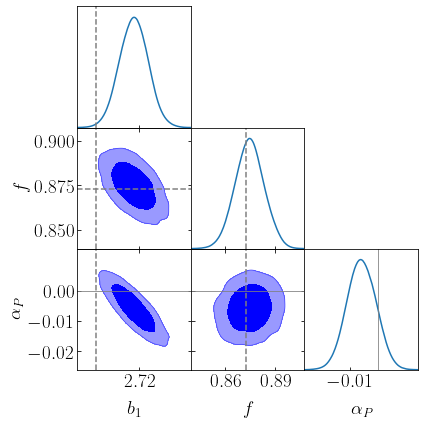

In [55]:
# Triangle plot
g = plots.get_subplot_plotter()
g.settings.alpha_filled_add=0.75
g.settings.axes_fontsize = 22
g.settings.lab_fontsize = 22
g.settings.legend_fontsize = 25
g.settings.lw_contour = 1.5

legend_loc_ = 'upper right'

g.triangle_plot([samples1], \
                contour_colors=['blue', 'green'], \
                line_args=[{'lw':1.5, 'color':'tab:blue'}, \
                           {'lw':1.5, 'color':'tab:green'}], \
                legend_loc= legend_loc_, filled=[True,True])

if fiducials != None:
    for i in range(len(names)):
        for j in range(i+1):
            ax = g.subplots[i,j]
            if i != j and names[i] in fiducials:
                                
                if names[i][0] != "a":
                    ax.axhline(fiducials[names[i]],ls='--',
                               color='tab:gray')
                else:                    
                    ax.axhline(fiducials[names[i]],ls='-',lw=0.8,
                               color='tab:gray')
                
                
            if names[j] in fiducials:
                
                
                if names[j][0] != "a":
                    ax.axvline(fiducials[names[j]],ls='--',
                               color='tab:gray')
                else:
                    ax.axvline(fiducials[names[j]],ls='-',lw=0.8,
                               color='tab:gray')

#plt.savefig('name.png', dpi = 300, bbox_inches = 'tight', facecolor = 'white', transparent='False')

print()